# Simple Linear Regression
#### The normalization and splitting dataset into train and test sets are essential. However, in the case of this dataset, due to its small size, these steps were not performed.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import optuna
import torch.optim as optim
import matplotlib.pyplot as plt

## Prepare the dataset

### Load the dataset

In [2]:
data = pd.read_csv('dataset.csv')
data

,Midterm,Final
0,78,66
1,83,73
2,56,76
3,67,65
4,85,81
5,44,54
6,32,29
7,90,85


### Numpy -> Tensor

In [3]:
X = data.drop(columns=['Final']).values
y = data['Final'].values

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (8, 1)
y shape: (8,)


In [4]:
X = torch.IntTensor(X)
y = torch.IntTensor(y).reshape(-1, 1)

## Plot the dataset

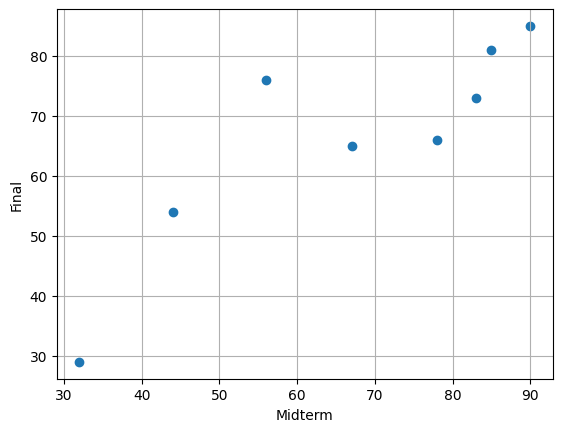

In [5]:
plt.scatter(X, y)
plt.grid(True)
plt.xlabel('Midterm')
plt.ylabel('Final')
plt.show()

## Functions to compute the models

### To optimize parameters using optuna

In [6]:
def objective(trial):
    num_epochs = trial.suggest_categorical('epoch_num', [100, 1000, 10000])
    lr = trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001, 0.00001])

    # define paremeters
    W = torch.zeros(1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    cost = train_model(W, b, num_epochs, lr, True)

    trial.report(cost, num_epochs)
    print(f'Trial {trial.number} - Epoch: {num_epochs}, lr: {lr}, Cost: {cost}')

    return cost

### To train the model

In [7]:
def train_model(W, b, num_epochs, lr, check_optuna):
    # set optimizer
    optimizer = optim.SGD([W, b], lr=lr)

    costs = []
    for epoch in range(num_epochs):
        hypothesis = X * W + b
        cost = torch.mean((hypothesis - y) ** 2)

        if check_optuna == True:
            if torch.isnan(cost) or torch.isinf(cost):
                raise optuna.TrialPruned()
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        costs.append(cost.item())

        if check_optuna == False:
            if epoch % (num_epochs // 10) == 0:
                print(f'Epoch: {epoch}/{num_epochs} - Cost: {cost.item()}')

    if check_optuna == False:
        return costs, hypothesis
    return cost.item()

## Study optuna

In [8]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

Trial 1 - Epoch: 1000, lr: 1e-05, Cost: 94.8082504272461
Trial 4 - Epoch: 1000, lr: 0.0001, Cost: 94.15706634521484
Trial 6 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 7 - Epoch: 1000, lr: 0.0001, Cost: 94.15706634521484
Trial 10 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 11 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 12 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 13 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 15 - Epoch: 10000, lr: 1e-05, Cost: 94.15647888183594
Trial 16 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 17 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 18 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 20 - Epoch: 10000, lr: 1e-05, Cost: 94.15647888183594
Trial 21 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 22 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 23 - Epoch: 10000, lr: 0.0001, Cost: 88.57300567626953
Trial 25 - Epoch: 10000, lr: 0.0001

## Best Parameters

In [9]:
best_params = study.best_params
print('Best parameters:', best_params)

best_epoch = best_params['epoch_num']
best_lr = best_params['lr']

Best parameters: {'epoch_num': 10000, 'lr': 0.0001}


## Train the model with best parameters

In [10]:
W = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

costs, hypothesis = train_model(W, b, best_epoch, best_lr, False)

Epoch: 0/10000 - Cost: 4653.625
Epoch: 1000/10000 - Cost: 94.15633392333984
Epoch: 2000/10000 - Cost: 93.45380401611328
Epoch: 3000/10000 - Cost: 92.7732925415039
Epoch: 4000/10000 - Cost: 92.11418914794922
Epoch: 5000/10000 - Cost: 91.47574615478516
Epoch: 6000/10000 - Cost: 90.857421875
Epoch: 7000/10000 - Cost: 90.25857543945312
Epoch: 8000/10000 - Cost: 89.678466796875
Epoch: 9000/10000 - Cost: 89.11665344238281


## Plot the cost with epoch

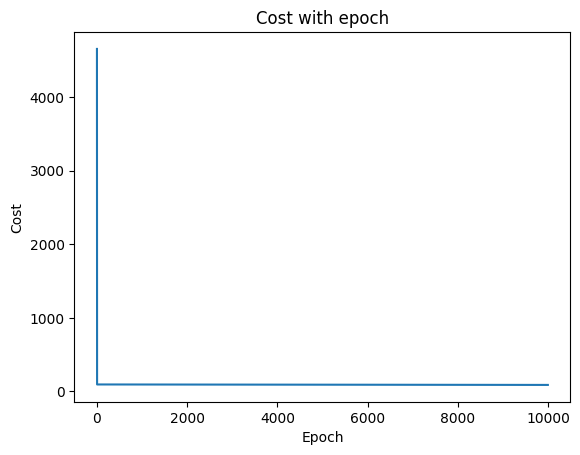

In [11]:
plt.plot(range(best_epoch), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost with epoch')
plt.show()

## Plot the model

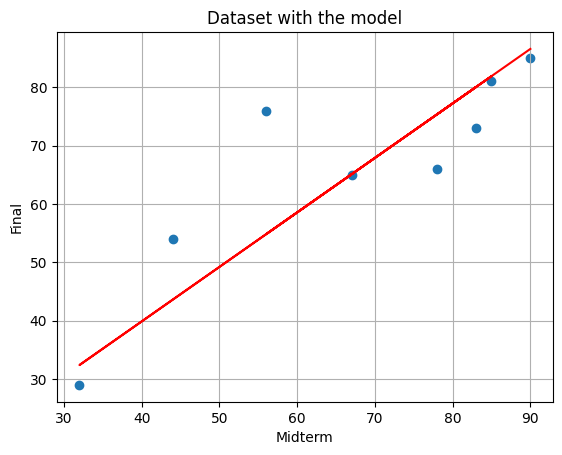

In [12]:
plt.scatter(X, y)
plt.plot(X.detach().numpy(), hypothesis.detach().numpy(), color='red')
plt.xlabel('Midterm')
plt.ylabel('Final')
plt.title('Dataset with the model')
plt.grid(True)
plt.show()

## Print trained W, b

In [13]:
print('Weights of the model:', W.item())
print('Bias of the model:', b.item())

Weights of the model: 0.9337682723999023
Bias of the model: 2.5222692489624023


## If Midterm = 71, Final = ?

In [14]:
midterm = 71
y_pred = int(W * midterm + b)
print('Final score is estimated as', y_pred)

Final score is estimated as 68
